In [ ]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.interpolate import Akima1DInterpolator
from function.model.cnn_w import Model
from torch.utils.data import DataLoader
from function.Dataset_w import CustomDataset
from function.function_w import get_path, get_device, train, evaluate
from function.model.cnn_w import Model

In [2]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT_PATH = os.getcwd()
PATH_DICT = get_path(ROOT_PATH)

DEVICE = get_device()
BATCH_SIZE = 128
EPOCHS = 500

model = Model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), 0.0005)
criterion = nn.CrossEntropyLoss()

Using PyTorch version: 2.6.0+cu124
Current device: cuda


In [4]:
train_dataset = CustomDataset(path_dict=PATH_DICT, run_type='train')
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)

val_dataset = CustomDataset(path_dict=PATH_DICT, run_type='val')
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_dataset.collate_fn)

test_dataset = CustomDataset(path_dict=PATH_DICT, run_type='test')
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_dataset.collate_fn)

Image files are already converted to Tensor.

Summary of the train dataset
(insect)	Camouflage       	images:	69
(insect)	Aposematism      	images:	28

Summary of the validation dataset
(insect)	Camouflage       	images:	10
(insect)	Aposematism      	images:	10

Summary of the test dataset
(insect)	Camouflage       	images:	10
(insect)	Aposematism      	images:	10



In [ ]:
result = {'train_loss':{}, 'val_loss':{}, 'val_accuracy': {}}
tqdm_bar = tqdm(range(1, EPOCHS+1))

for epoch in tqdm_bar:
  train_loss = train(model, train_loader, optimizer, criterion, device=DEVICE)
  val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=DEVICE)

  result['train_loss'][epoch] = train_loss
  result['val_loss'][epoch] = val_loss
  result['val_accuracy'][epoch] = val_accuracy

  # if (epoch == 140):
  #   torch.save(model.state_dict(), f'{PATH_DICT["save_path"]}\\cnn_w_ver1.pt')
  
  tqdm_bar.set_description(f"[EPOCH {epoch:3d}] Val Accuracy: {val_accuracy:.2f} %")

tqdm_bar.close()

[EPOCH 500] Val Accuracy: 81.25 %: 100%|██████████| 500/500 [47:31<00:00,  5.70s/it]


In [6]:
model = Model().to(DEVICE)
model.load_state_dict(torch.load(PATH_DICT['save_path'] + '\\cnn_w_ver1.pt'))

test_loss, test_accuracy = evaluate(model, test_loader, criterion, device=DEVICE)
print(f"Test Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy:.2f} %")

Test Loss: 0.0041	Test Accuracy: 93.75 %


In [7]:
x = list(result['train_loss'].keys())
y_train = list(result['train_loss'].values())
y_val = list(result['val_loss'].values())
y_accuracy = list(result['val_accuracy'].values())

print(f'EPOCH {x[np.argmin(y_val)]}\tMIN TEST LOSS {np.min(y_val):.4f}')
print(f'EPOCH {x[np.argmax(y_accuracy)]}\tBEST ACCURACY {np.max(y_accuracy)}')

A1 = Akima1DInterpolator(x, y_train)
A2 = Akima1DInterpolator(x, y_val)
A3 = Akima1DInterpolator(x, y_accuracy)

x_new = np.linspace(1, 501, 300)
y_train_new = A1(x_new)
y_val_new = A2(x_new)
y_accuracy_new = A3(x_new)

EPOCH 303	MIN TEST LOSS 0.0030
EPOCH 140	BEST ACCURACY 92.5


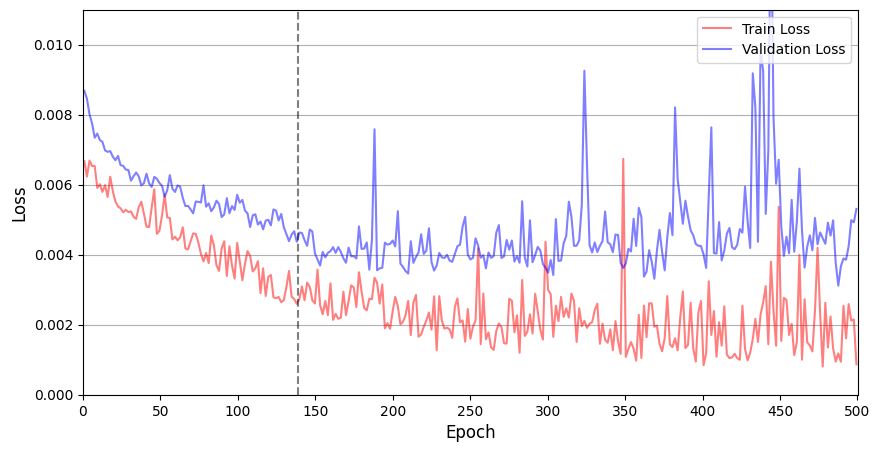

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_xlim([0, 500.2])
ax.set_ylim([0, 0.011])
ax.set_xticks(np.arange(0, 501, 50))

ax.plot(x_new, y_train_new, '-', color='red', alpha=0.5, label='Train Loss')
ax.plot(x_new, y_val_new, '-', color='blue', alpha=0.5, label='Validation Loss')
ax.plot([139, 139], [0, 1], '--', color='black', alpha=0.5)
ax.grid(True, axis='y')
ax.legend(loc=1)

plt.show()

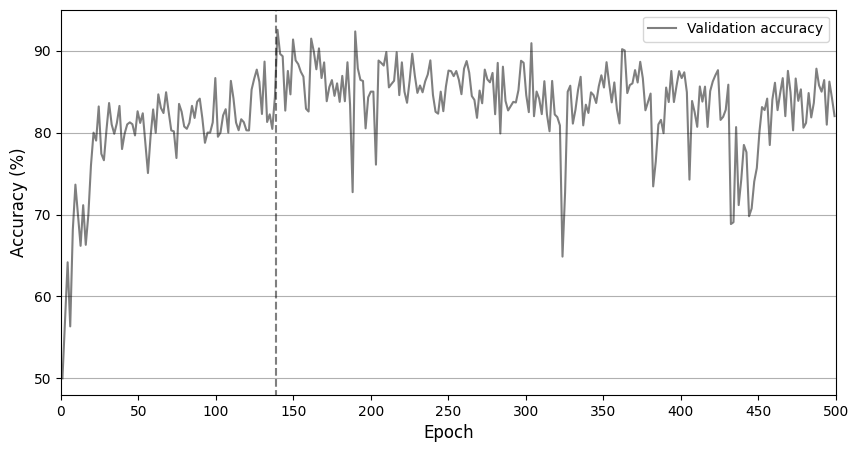

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlim([0, 500.2])
ax.set_ylim([48, 95])
ax.set_xticks(np.arange(0, 501, 50))

ax.plot(x_new, y_accuracy_new, '-', color='black', alpha=0.5, label='Validation accuracy')
ax.plot([139, 139], [0, 100], '--', color='black', alpha=0.5)

ax.grid(True, axis='y')
ax.legend(loc=1)

plt.show()